In [2]:
import os
os.chdir("d:/python_projects/london-city-bikes")

import numpy as np
import torch
import matplotlib.pyplot as plt
import mlflow

In [ ]:
from src.dataset_all_clusters import get_dataloaders
from src.model import LSTMModel, LinearWeightedMSELoss
from src.train import train_model, DEVICE
from src.metrics import evaluate_predictions
from src.predict import predict
from src.mlflow_logging import log_trained_model, log_true_and_predictions_values
from src.mlflow_logging import log_model_architecture
from src.mlflow_logging import log_train_parameters_with_embedding

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

c:\Users\huber\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
PRED_LENGTH = 48
MODELS_BASENAME = "pytorch_model"
MODEL_PATH = f'./data/models/{MODELS_BASENAME}_with_embeddings.pth'
CHECKPOINT_PATH = './data/models/checkpoint_with_embeddings.pth'

print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
train_dataloader, val_dataloader, cluster_id_map = get_dataloaders()

In [6]:
len(train_dataloader)

109

In [7]:
len(val_dataloader)

28

# Training

In [17]:
# Hyperparameters
INPUT_SIZE = 12
FUTURE_FEATURE_SIZE = 10
HIDDEN_SIZE = 128
OUTPUT_SIZE = 2 * PRED_LENGTH
NUM_LAYERS = 1
NUM_EPOCHS = 10
DROPOUT = 0
LEARNING_RATE = 0.0001
USE_CLUSTER_EMBEDDING = True

In [8]:
# Hyperparameters
INPUT_SIZE = 12
FUTURE_FEATURE_SIZE = 10
HIDDEN_SIZE = 512
OUTPUT_SIZE = 2 * PRED_LENGTH
NUM_LAYERS = 2
NUM_EPOCHS = 20
DROPOUT = 0
LEARNING_RATE = 0.0001
USE_CLUSTER_EMBEDDING = True

# Train one model for all clusters

train
Epoch [1/20] - Train Loss: 0.0238, Train MAE: 0.0941, Val Loss: 0.0108, Val MAE: 0.0658
Epoch [2/20] - Train Loss: 0.0067, Train MAE: 0.0534, Val Loss: 0.0072, Val MAE: 0.0514
Epoch [3/20] - Train Loss: 0.0047, Train MAE: 0.0437, Val Loss: 0.0060, Val MAE: 0.0450
Epoch [4/20] - Train Loss: 0.0036, Train MAE: 0.0372, Val Loss: 0.0053, Val MAE: 0.0412
Epoch [5/20] - Train Loss: 0.0031, Train MAE: 0.0341, Val Loss: 0.0049, Val MAE: 0.0388
Epoch [6/20] - Train Loss: 0.0028, Train MAE: 0.0322, Val Loss: 0.0047, Val MAE: 0.0377
Epoch [7/20] - Train Loss: 0.0026, Train MAE: 0.0310, Val Loss: 0.0046, Val MAE: 0.0376
Epoch [8/20] - Train Loss: 0.0025, Train MAE: 0.0299, Val Loss: 0.0043, Val MAE: 0.0359
Epoch [9/20] - Train Loss: 0.0024, Train MAE: 0.0291, Val Loss: 0.0040, Val MAE: 0.0347
Epoch [10/20] - Train Loss: 0.0023, Train MAE: 0.0284, Val Loss: 0.0039, Val MAE: 0.0342
Epoch [11/20] - Train Loss: 0.0022, Train MAE: 0.0279, Val Loss: 0.0029, Val MAE: 0.0317
Epoch [12/20] - Train Lo

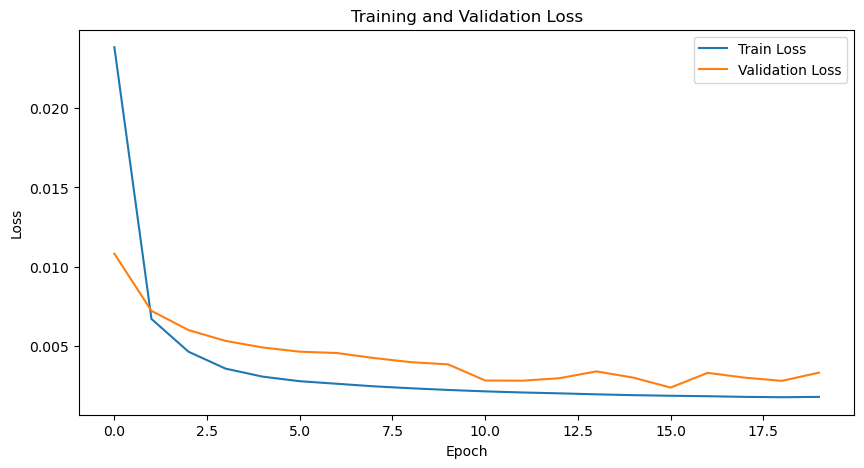

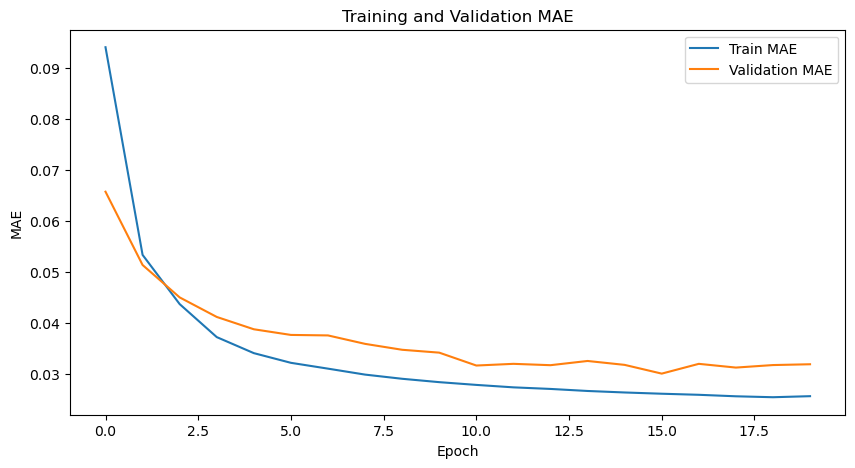

2025/04/26 16:28:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/26 16:28:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/26 16:28:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


predict
evaluate
Metrics:
  MAE: 9.5300, RMSE: 15.0183, R2: 0.9181, sMAPE: 54.7121%


In [9]:
model = LSTMModel(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    future_feature_size=FUTURE_FEATURE_SIZE,
    output_size=OUTPUT_SIZE,
    pred_length=PRED_LENGTH,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    use_cluster_embedding=USE_CLUSTER_EMBEDDING,
    num_clusters=len(cluster_id_map),
    cluster_emb_size=8
).to(DEVICE)

criterion = LinearWeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

mlflow.start_run()
log_model_architecture(model)
log_train_parameters_with_embedding(NUM_EPOCHS, optimizer, criterion, train_dataloader.batch_size, USE_CLUSTER_EMBEDDING)
print("train")
model, checkpoint = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs=NUM_EPOCHS)
torch.save(model, MODEL_PATH)
torch.save(checkpoint, CHECKPOINT_PATH)
log_trained_model(model, MODELS_BASENAME + "_with_embedding.pth")

all_preds = {}
all_true = {}
print("predict")
preds, true_vals, metadata = predict(model, val_dataloader)
print("evaluate")
metrics = evaluate_predictions(true_vals, preds, metadata)
print(f"Metrics:")
print(f"  MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}, sMAPE: {metrics['sMAPE']:.4f}%")

np.save(f"./data/results/true_values.npy", true_vals)
np.save(f"./data/results/predictions.npy", preds)
log_true_and_predictions_values(f"./data/results/true_values.npy", f"./data/results/predictions.npy")

mlflow.end_run()

In [10]:
48*365*30*0.2

105120.0

In [11]:
len(true_vals)

6932

In [14]:
index = PRED_LENGTH * 1

selected_true = true_vals[index]
selected_predictions = preds[index]

# Extract true and predicted values for Starts and Ends
true_starts = selected_true[:, 0]  # Shape: (pred_length)
true_ends = selected_true[:, 1]    # Shape: (pred_length)
pred_starts = selected_predictions[:, 0]  # Shape: (pred_length)
pred_ends = selected_predictions[:, 1]    # Shape: (pred_length)

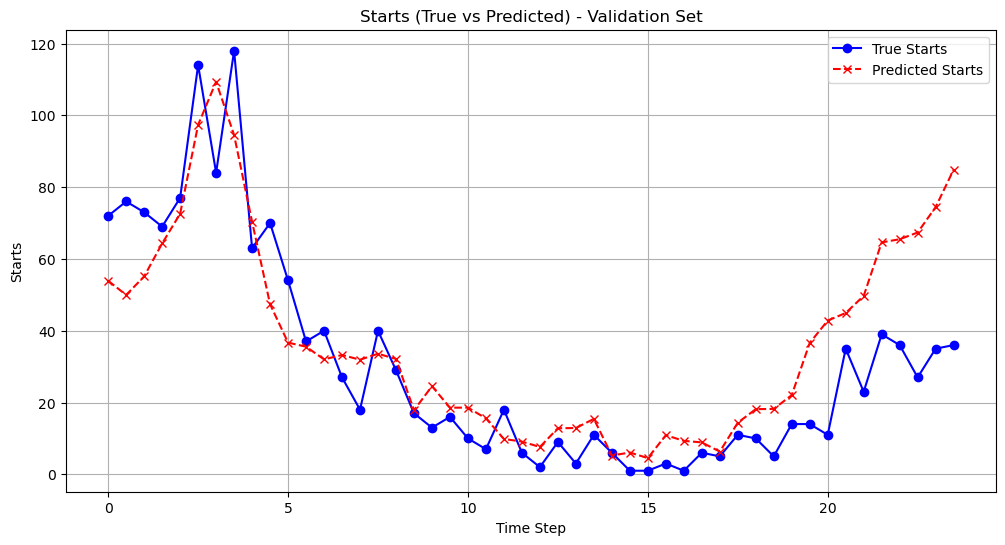

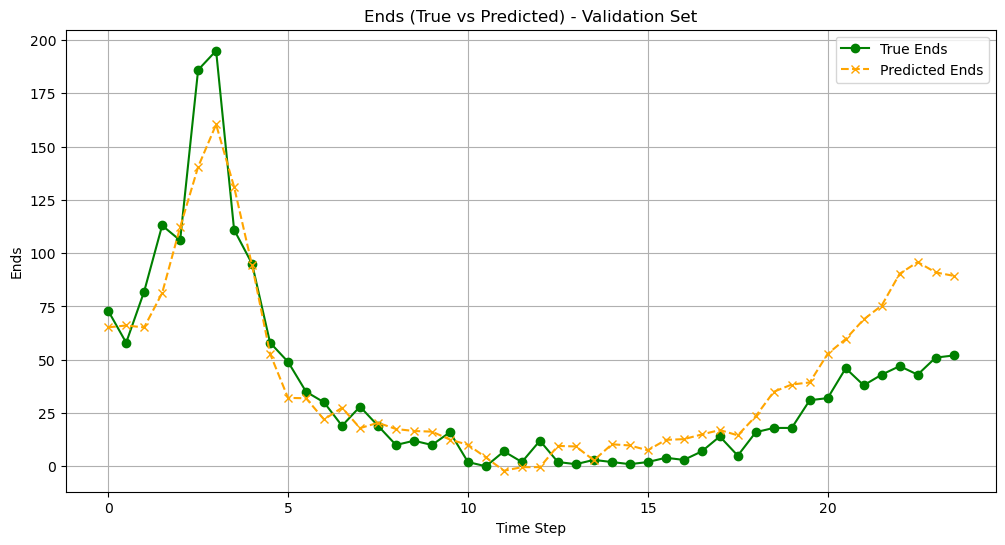

In [15]:
# Plot Starts for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_starts, label="True Starts", color="blue", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_starts, label="Predicted Starts", color="red", linestyle="--", marker="x")
plt.title(f"Starts (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Starts")
plt.legend()
plt.grid(True)
plt.show()

# Plot Ends for the first sample in the batch
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), true_ends, label="True Ends", color="green", marker="o")
plt.plot(np.linspace(0, PRED_LENGTH/2 - 0.5, PRED_LENGTH), pred_ends, label="Predicted Ends", color="orange", linestyle="--", marker="x")
plt.title(f"Ends (True vs Predicted) - Validation Set")
plt.xlabel("Time Step")
plt.ylabel("Ends")
plt.legend()
plt.grid(True)
plt.show()